Carga de DataFrames de Pandas --- 0:00 min
===

* Última modificación: Marzo 1, 2022 | YouTube

In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import pandas as pd
import tensorflow as tf

Lectura de datos usando Pandas
---

In [2]:
SHUFFLE_BUFFER = 500
BATCH_SIZE = 2

In [3]:
csv_file = tf.keras.utils.get_file(
    "heart.csv",
    "https://storage.googleapis.com/download.tensorflow.org/data/heart.csv",
)

In [4]:
#
# Lecura
#
df = pd.read_csv(csv_file)
df.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

   ca        thal  target  
0   0       fixed       0  
1   3      normal       1  
2   2  reversible       0  
3   0      normal       0  
4   0      normal       0

In [5]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal         object
target        int64
dtype: object

In [6]:
#
# Extracción de la variable respuesta
#
target = df.pop("target")

Extracción de características numéricas
---

In [7]:
numeric_feature_names = [
    "age",
    "thalach",
    "trestbps",
    "chol",
    "oldpeak",
]
numeric_features = df[numeric_feature_names]
numeric_features.head()

age  thalach  trestbps  chol  oldpeak
0   63      150       145   233      2.3
1   67      108       160   286      1.5
2   67      129       120   229      2.6
3   37      187       130   250      3.5
4   41      172       130   204      1.4

In [8]:
tf.convert_to_tensor(numeric_features)

<tf.Tensor: shape=(303, 5), dtype=float64, numpy=
array([[ 63. , 150. , 145. , 233. ,   2.3],
       [ 67. , 108. , 160. , 286. ,   1.5],
       [ 67. , 129. , 120. , 229. ,   2.6],
       ...,
       [ 65. , 127. , 135. , 254. ,   2.8],
       [ 48. , 150. , 130. , 256. ,   0. ],
       [ 63. , 154. , 150. , 407. ,   4. ]])>

Manejo de un DataFrame como un array con Model.fit()
---

In [9]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(numeric_features)

#
# Ejemplo
#
normalizer(numeric_features.iloc[:3])

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[ 0.93383914,  0.03480718,  0.74578077, -0.2600867 ,  1.0680453 ],
       [ 1.3782105 , -1.7806165 ,  1.5923285 ,  0.7573879 ,  0.38022864],
       [ 1.3782105 , -0.87290466, -0.6651321 , -0.3368772 ,  1.3259765 ]],
      dtype=float32)>

In [10]:
def get_basic_model():
    model = tf.keras.Sequential(
        [
            normalizer,
            tf.keras.layers.Dense(10, activation="relu"),
            tf.keras.layers.Dense(10, activation="relu"),
            tf.keras.layers.Dense(1),
        ]
    )

    model.compile(
        optimizer="adam",
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    return model

In [11]:
model = get_basic_model()

model.fit(
    numeric_features,
    target,
    epochs=5,
    batch_size=BATCH_SIZE,
)

Epoch 1/5
152/152 [==============================] - 1s 2ms/step - loss: 0.6544 - accuracy: 0.7393
Epoch 2/5
152/152 [==============================] - 0s 2ms/step - loss: 0.5654 - accuracy: 0.7261
Epoch 3/5
152/152 [==============================] - 0s 2ms/step - loss: 0.5058 - accuracy: 0.7261
Epoch 4/5
152/152 [==============================] - 1s 9ms/step - loss: 0.4779 - accuracy: 0.7228
Epoch 5/5
152/152 [==============================] - 0s 3ms/step - loss: 0.4588 - accuracy: 0.7393


Manejo de un DataFrame con tf.data
---

In [12]:
numeric_dataset = tf.data.Dataset.from_tensor_slices(
    (numeric_features, target),
)

for row in numeric_dataset.take(3):
    print(row)

(<tf.Tensor: shape=(5,), dtype=float64, numpy=array([ 63. , 150. , 145. , 233. ,   2.3])>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(5,), dtype=float64, numpy=array([ 67. , 108. , 160. , 286. ,   1.5])>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(5,), dtype=float64, numpy=array([ 67. , 129. , 120. , 229. ,   2.6])>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [13]:
numeric_batches = numeric_dataset.shuffle(1000)
numeric_batches = numeric_batches.batch(BATCH_SIZE)

model = get_basic_model()
model.fit(numeric_batches, epochs=5)

Epoch 1/5
152/152 [==============================] - 1s 3ms/step - loss: 0.6342 - accuracy: 0.7261
Epoch 2/5
152/152 [==============================] - 0s 2ms/step - loss: 0.5535 - accuracy: 0.7261
Epoch 3/5
152/152 [==============================] - 0s 3ms/step - loss: 0.5009 - accuracy: 0.7261
Epoch 4/5
152/152 [==============================] - 0s 3ms/step - loss: 0.4766 - accuracy: 0.7426
Epoch 5/5
152/152 [==============================] - 0s 3ms/step - loss: 0.4642 - accuracy: 0.7459


Manejo de un DataFrame como un diccionario y Model-subclass
---

In [15]:
numeric_dict_ds = tf.data.Dataset.from_tensor_slices(
    (dict(numeric_features), target),
)

for row in numeric_dict_ds.take(3):
    print(row)

({'age': <tf.Tensor: shape=(), dtype=int64, numpy=63>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=150>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=145>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=233>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=2.3>}, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
({'age': <tf.Tensor: shape=(), dtype=int64, numpy=67>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=108>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=160>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=286>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=1.5>}, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
({'age': <tf.Tensor: shape=(), dtype=int64, numpy=67>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=129>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=120>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=229>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=2.6>}, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [16]:
def stack_dict(inputs, fun=tf.stack):
    values = []
    for key in sorted(inputs.keys()):
        values.append(tf.cast(inputs[key], tf.float32))

    return fun(values, axis=-1)

In [17]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super().__init__(self)

        self.normalizer = tf.keras.layers.Normalization(axis=-1)

        self.sequential = tf.keras.Sequential(
            [
                self.normalizer,
                tf.keras.layers.Dense(10, activation="relu"),
                tf.keras.layers.Dense(10, activation="relu"),
                tf.keras.layers.Dense(1),
            ]
        )

    def adapt(self, inputs):
        inputs = stack_dict(inputs)
        self.normalizer.adapt(inputs)

    def call(self, inputs):
        inputs = stack_dict(inputs)
        result = self.sequential(inputs)
        return result


model = MyModel()

model.adapt(dict(numeric_features))

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
    run_eagerly=True,
)

model.fit(
    dict(numeric_features),
    target,
    epochs=5,
    batch_size=BATCH_SIZE,
)

Epoch 1/5
152/152 [==============================] - 4s 27ms/step - loss: 0.5713 - accuracy: 0.7261
Epoch 2/5
152/152 [==============================] - 4s 26ms/step - loss: 0.5063 - accuracy: 0.7261
Epoch 3/5
152/152 [==============================] - 4s 25ms/step - loss: 0.4741 - accuracy: 0.7261
Epoch 4/5
152/152 [==============================] - 4s 25ms/step - loss: 0.4578 - accuracy: 0.7393
Epoch 5/5
152/152 [==============================] - 4s 25ms/step - loss: 0.4493 - accuracy: 0.7591


In [18]:
#
# Ejemplo con batches
#
numeric_dict_batches = numeric_dict_ds.shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)

model.fit(
    numeric_dict_batches,
    epochs=5,
)

Epoch 1/5
152/152 [==============================] - 3s 22ms/step - loss: 0.4433 - accuracy: 0.7723
Epoch 2/5
152/152 [==============================] - 3s 22ms/step - loss: 0.4396 - accuracy: 0.7789
Epoch 3/5
152/152 [==============================] - 3s 22ms/step - loss: 0.4358 - accuracy: 0.7888
Epoch 4/5
152/152 [==============================] - 3s 22ms/step - loss: 0.4326 - accuracy: 0.7855
Epoch 5/5
152/152 [==============================] - 3s 23ms/step - loss: 0.4323 - accuracy: 0.7855


In [19]:
model.predict(dict(numeric_features.iloc[:3]))

array([[[0.26080817]],

       [[0.69308937]],

       [[0.42168024]]], dtype=float32)

Manejo de un DataFrame como un diccionario y API funcional
---

In [20]:
inputs = {}
for name, column in numeric_features.items():
    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=tf.float32)

inputs

{'age': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age')>,
 'thalach': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'thalach')>,
 'trestbps': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'trestbps')>,
 'chol': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'chol')>,
 'oldpeak': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'oldpeak')>}

In [21]:
x = stack_dict(inputs, fun=tf.concat)

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(stack_dict(dict(numeric_features)))

x = normalizer(x)
x = tf.keras.layers.Dense(10, activation="relu")(x)
x = tf.keras.layers.Dense(10, activation="relu")(x)
x = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs, x)

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
    run_eagerly=True,
)

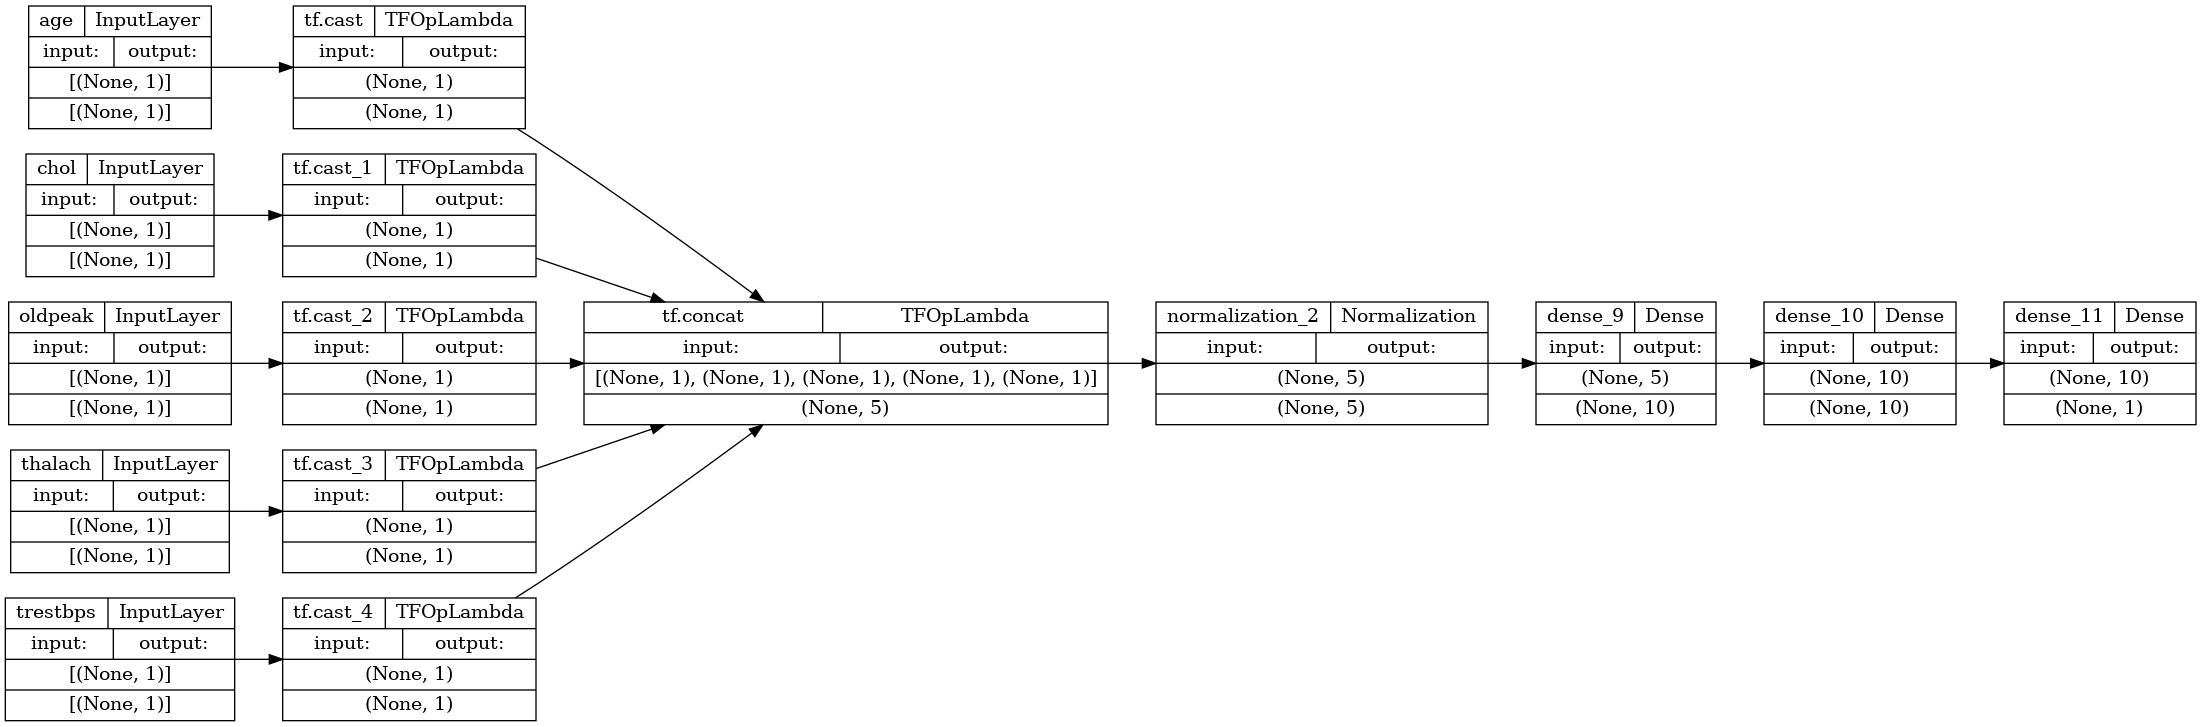

In [22]:
tf.keras.utils.plot_model(model, rankdir="LR", show_shapes=True)

In [23]:
model.fit(dict(numeric_features), target, epochs=5, batch_size=BATCH_SIZE)

Epoch 1/5
152/152 [==============================] - 4s 25ms/step - loss: 0.6575 - accuracy: 0.7129
Epoch 2/5
152/152 [==============================] - 4s 25ms/step - loss: 0.5586 - accuracy: 0.7261
Epoch 3/5
152/152 [==============================] - 4s 25ms/step - loss: 0.5116 - accuracy: 0.7261
Epoch 4/5
152/152 [==============================] - 4s 24ms/step - loss: 0.4858 - accuracy: 0.7261
Epoch 5/5
152/152 [==============================] - 4s 24ms/step - loss: 0.4684 - accuracy: 0.7261
